In [60]:
from langchain_groq import ChatGroq
model = ChatGroq(model = 'qwen/qwen3-32b')


In [61]:
from langchain.document_loaders import TextLoader
doc = TextLoader('info.txt')
docs = doc.load()


In [62]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 100 , chunk_overlap = 10 )
docs_splits = text_splitter.split_documents(docs)

In [63]:
for doc in docs_splits:
    doc.metadata['author'] = "Shahbaz"

In [64]:
import os
os.environ['HUGGINGFACE_API_KEY'] = os.getenv("HUGGINGFACE_API_KEY")
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [65]:
docs_splits

from langchain_community.vectorstores import FAISS

vector_store = FAISS.from_documents(
    documents=docs_splits,
    embedding=embeddings
)
retriever = vector_store.as_retriever()

s:\AI_AGENTS\Python_N_Env\LangGraph\graphenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [81]:
## Question Grader
from pydantic import Field , BaseModel
from langchain_core.prompts import ChatPromptTemplate
class QuestionGrader(BaseModel):
    """Binary score the question based on relevance with queried documents"""
    binaryscore : str = Field(description="Score the question 'yes' or 'no' based on the relevance with retrieved documents")
llm_with_structured = model.with_structured_output(QuestionGrader)
system = """You are an expert classifier which classify the question based on the documents given whether the question is relevant to the documents or not if question is not relevant return 'no' otherwise return 'yes'
"""
prompt = ChatPromptTemplate([
    ('system' , system),
    ('human' , "The question is : {question} Documents are \n {documents}")
])

question_grader = prompt | llm_with_structured
question = "what is agentic AI"
docs = retriever.invoke(question)
res = question_grader.invoke({"question" : question , 'documents' : docs})


    

s:\AI_AGENTS\Python_N_Env\LangGraph\graphenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [82]:
res

QuestionGrader(binaryscore='yes')

# **`Question Decider`**

In [86]:
def question_decider(state):
    question = state["question"]
    docs = retriever.invoke(question)  # or use state['documents'] if already set
    grade = question_grader.invoke({"question": question, 'documents': docs})
    score = grade.binaryscore
    if score == 'yes':
        print("----- Question is relative to the documents -----")
        return 'retrieve'
    else:
        print("Sorry question is not relative to the uploaded documents. Please ask a related question.")
        return 'end'


# **`Retrieval Grader`**

In [69]:
class DocumentGrader(BaseModel):
    """Binary score for relevance check on the retrieved documents"""
    binaryscore : str = Field(description="Check whether the retrieved documents are related to the question or not if yes return 'yes' otherwise 'no'")

model = ChatGroq(model='qwen/qwen3-32b')
llm_with_str = model.with_structured_output(DocumentGrader)

system = """You are an expert Document Grader which classify whether the retrieved documents are semantically related to the user question or not if not return 'no' and if they are related return 'yes'
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question (user query)."""
prompt = ChatPromptTemplate([
    ('system' , system),
    ('human' , "Retrieved document: \n\n {documents} \n\n User question: {question}")
])

retrieval_grader = prompt | llm_with_str

question = "what is Machine Learning"
docs = retriever.invoke(question)
doc = docs[0]
retrieval_grader.invoke({"documents" : doc, 'question' : question})

s:\AI_AGENTS\Python_N_Env\LangGraph\graphenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


DocumentGrader(binaryscore='yes')

# **`RAG Chain`**

In [70]:


from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatGroq(model = 'llama-3.3-70b-versatile')


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Machine Learning is a powerful branch of Artificial Intelligence that enables computers to learn. It can be broadly categorized into supervised learning, where models are trained on labeled data. Machine learning has various applications, including fraud detection, medical diagnostics, and self-driving cars.


# **`Question Rewriter`**

In [71]:
llm = ChatGroq(model = 'llama-3.3-70b-versatile')

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning
     Remember just output question only no extra information Strictly
     """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the definition and application of Machine Learning in artificial intelligence?'

# **`Answer Grader`**

In [72]:
class AnswerGrader(BaseModel):
    """Binary Score the Answer Whether it satisfy the question"""
    binaryscore : str = Field(description="Answer addresses the question, 'yes' or 'no'")

llm = ChatGroq(model = 'qwen/qwen3-32b')
structured_llm_grader = llm.with_structured_output(AnswerGrader)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

AnswerGrader(binaryscore='yes')

# **`Nodes Definition`**

In [73]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question : str
    generation : str
    documents : List[str]

In [ ]:
def retrieve(state : GraphState):
    """
    Retrieve the documents from Vector DB
    Args :
        state (dict) : the current state of Graph

    Returns:
        state (dict) : the updated state of Graph after Retrieval 
    """

    question = state['question']
    docs = retriever.invoke(question)
    return {"documents" : docs}

def generate(state : GraphState):
    """
    Generate answer and give

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state : GraphState):
    """
    Grade the documents whether they are related to the question or not
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    filtered_docs = []
    docs = state['documents']
    question = state['question']  
    for d in docs  :
        grade = retrieval_grader.invoke({'documents' : d , "question" : question})
        score = grade.binaryscore
        if (score == 'yes'):
            print("__ Document is Related __")
            filtered_docs.append(d)
        else:
            print("__ Documents are not related __")
            continue

    return {'documents' : filtered_docs , 'question' : question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def answer_checker(state):
    """Checks whether the Answer generated by LLM address the question thorougly or not
    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    generation = state['generation']
    question = state['question']
    ans_grade = answer_grader.invoke({"question" : question , "generation" : generation})
    score = ans_grade.binaryscore
    if (score == 'yes'):
        print("__ LLM generation Answers the question correctly __")
        return 'end'
    else:
        print("__ Generation does not answer the question __")
        return 'rewrite'
    

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


# **`Graph Definition`**

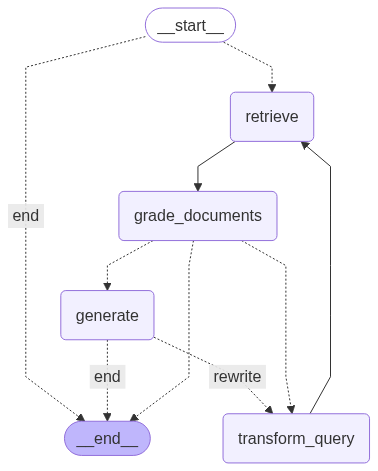

In [88]:
from langgraph.graph import END, StateGraph, START

builder = StateGraph(GraphState)
builder.add_node('retrieve' , retrieve)
builder.add_node('generate' , generate)
builder.add_node('transform_query' , transform_query)
builder.add_node('grade_documents' , grade_documents)

### defining the workflow

builder.add_conditional_edges(START , question_decider , 
                              {
                                  'retrieve' : 'retrieve',
                                  'end' : END
                              })
builder.add_edge('retrieve' , 'grade_documents' )
builder.add_conditional_edges('grade_documents' , decide_to_generate , 
                              {
                                  'transform_query' : 'transform_query',
                                  'generate' : 'generate'
                              })
builder.add_edge('transform_query' , 'retrieve')
builder.add_conditional_edges('generate' , answer_checker , 
                 {
                     'end' : END,
                     'rewrite' : 'transform_query'
                 })

graph = builder.compile()
from IPython.display import Image, display, Markdown
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [90]:
graph.invoke({"question" : "What are the Advantages of Machine Learning"})

s:\AI_AGENTS\Python_N_Env\LangGraph\graphenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


----- Question is relative to the documents -----


s:\AI_AGENTS\Python_N_Env\LangGraph\graphenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


__ Documents are not related __
__ Document is Related __
__ Document is Related __
__ Documents are not related __
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
__ LLM generation Answers the question correctly __


{'question': 'What are the Advantages of Machine Learning',
 'generation': "The advantages of machine learning include the ability to learn from data and improve performance over time without being explicitly programmed. This allows for efficient processing and analysis of large amounts of data. I don't know the full list of advantages, as the provided context is limited.",
 'documents': [Document(id='1cb37a2e-9e9a-4cd1-8699-758a9c42be5c', metadata={'source': 'info.txt', 'author': 'Shahbaz'}, page_content='to learn from data and improve their performance over time without being explicitly programmed for'),
  Document(id='6b0d0e83-967a-4c49-b3f0-9b197ddd7d11', metadata={'source': 'info.txt', 'author': 'Shahbaz'}, page_content='predictions. With the growing availability of data and computational power, machine learning is')]}

AIMessage(content='<think>\nOkay, the user said "hello". That\'s a greeting. I should respond in a friendly way. Maybe ask how they\'re doing and offer help. Keep it simple and open-ended. Let them know I\'m here to assist with any questions they have.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 9, 'total_tokens': 77, 'completion_time': 0.143173102, 'prompt_time': 0.000209026, 'queue_time': 0.006523482, 'total_time': 0.143382128}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--418819c2-984c-4bd8-8f07-e2fa4e6ea32a-0', usage_metadata={'input_tokens': 9, 'output_tokens': 68, 'total_tokens': 77})